In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, ResNet50, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

2024-07-02 17:46:26.962212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 17:46:28.208216: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#Diretórios
train_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/train'
val_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/val'
test_dir = r'/media/breno/08FE0999FE097FE4/Breno/TCC/binary_final/test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 16

#CLasses
num_classes = 2

In [3]:
#Data generators
#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [8]:
#Transfer learning com a densenet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

#total = 200 + 4109
#weight_for_0 = (1 / 200) * (total / 2.0)
#weight_for_1 = (1 / 4109) * (total / 2.0)
#class_weights = {0: weight_for_0, 1: weight_for_1}

In [9]:
#lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001, verbose=1)
adam = Adam(learning_rate=0.0005)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#FAZER DEPOIS COM 0.0001

In [10]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [11]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 986s 4s/step - accuracy: 0.9426 - loss: 3.8659 - val_accuracy: 0.7273 - val_loss: 51.1311
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 964s 4s/step - accuracy: 0.9862 - loss: 0.5884 - val_accuracy: 0.7309 - val_loss: 52.7184
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 963s 4s/step - accuracy: 0.9946 - loss: 0.1303 - val_accuracy: 0.7236 - val_loss: 71.6409
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 983s 4s/step - accuracy: 0.9952 - loss: 0.1995 - val_accuracy: 0.7200 - val_loss: 52.2764
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 0.9938 - loss: 0.1187 - val_accuracy: 0.7236 - val_loss: 70.4476
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 0.9974 - loss: 0.1255 - val_accuracy: 0.7273 - val_loss: 79.2083
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 965s 4s/step - accuracy: 1.0000 - loss: 1.0723e-08 - val_accuracy: 0.7273 - val_loss: 79.2180
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 966s 4s/step - accuracy: 1.0000 - loss

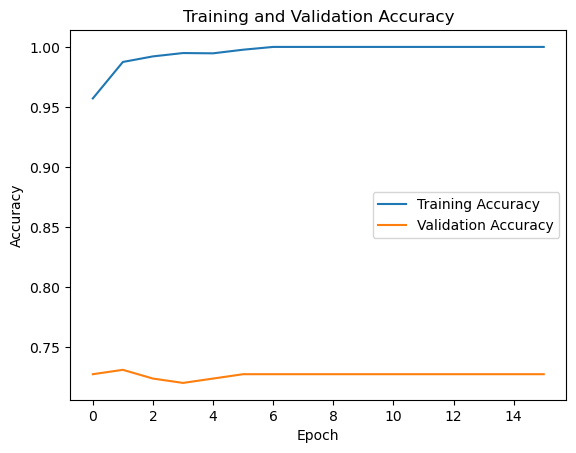

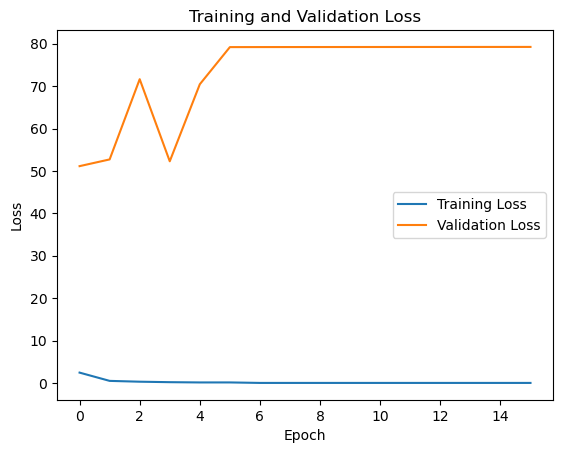

In [12]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step - accuracy: 0.7286 - loss: 17.0625
Test Accuracy: 85.99%
Test Loss: 8.8399


In [14]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step


array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [15]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

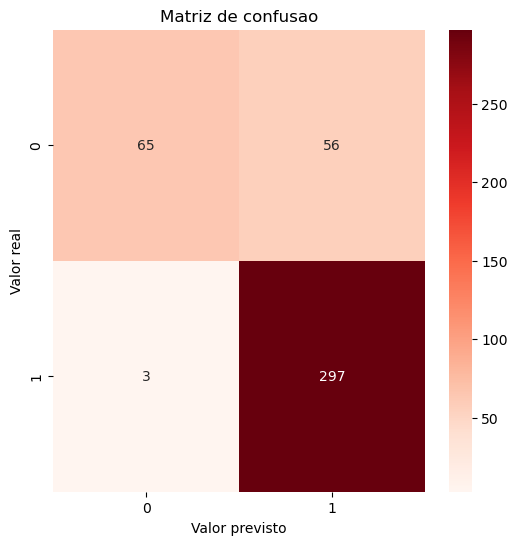

In [16]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [17]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 85.99%


In [18]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)
#print(79/(79+42))

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)
#print(296/(296+4))


0.5371900826446281
0.99


In [19]:
#Data generators

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#train_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#val_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)
#test_datagen = ImageDataGenerator(dtype = 'float32', preprocessing_function=tf.keras.applications.resnet.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False)

Found 4309 images belonging to 2 classes.
Found 275 images belonging to 2 classes.
Found 421 images belonging to 2 classes.


In [20]:
#Transfer learning com a densenet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

#total = 200 + 4109
#weight_for_0 = (1 / 200) * (total / 2.0)
#weight_for_1 = (1 / 4109) * (total / 2.0)
#class_weights = {0: weight_for_0, 1: weight_for_1}

In [21]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [23]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


/home/breno/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 1064s 4s/step - accuracy: 0.9459 - loss: 2.4502 - val_accuracy: 0.7236 - val_loss: 39.1267
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1045s 4s/step - accuracy: 0.9813 - loss: 0.4608 - val_accuracy: 0.7236 - val_loss: 25.6416
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1048s 4s/step - accuracy: 0.9890 - loss: 0.1664 - val_accuracy: 0.7236 - val_loss: 43.0625
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1048s 4s/step - accuracy: 0.9847 - loss: 0.3651 - val_accuracy: 0.7273 - val_loss: 38.3113
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1052s 4s/step - accuracy: 0.9967 - loss: 0.0582 - val_accuracy: 0.7273 - val_loss: 35.8091
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1049s 4s/step - accuracy: 0.9975 - loss: 0.0672 - val_accuracy: 0.7236 - val_loss: 50.8760
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1050s 4s/step - accuracy: 0.9941 - loss: 0.1033 - val_accuracy: 0.7236 - val_loss: 44.7104
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 1053s 4s/step - accuracy: 0.9957 - loss: 0.1082

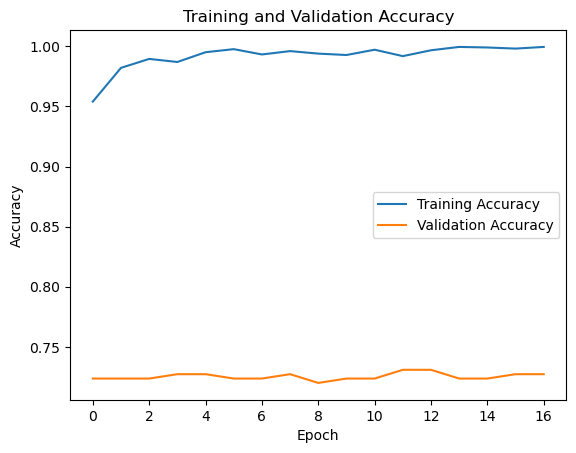

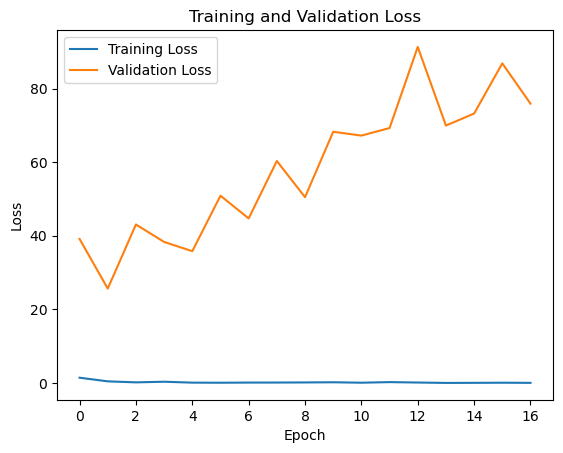

In [24]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8381 - loss: 5.7314
Test Accuracy: 91.69%
Test Loss: 2.7725


In [26]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step


array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

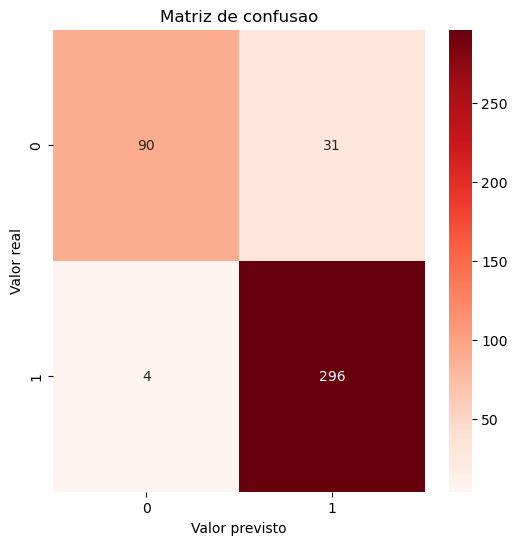

In [28]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [29]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 91.69%


In [30]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)
#print(79/(79+42))

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)
#print(296/(296+4))


0.743801652892562
0.9866666666666667


In [31]:
#Transfer learning com a densenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 2 classes
for layer in base_model.layers:
    layer.trainable = False

#Mais simples possivel - apenas com uso do softmax final
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid') 
])

#total = 200 + 4109
#weight_for_0 = (1 / 200) * (total / 2.0)
#weight_for_1 = (1 / 4109) * (total / 2.0)
#class_weights = {0: weight_for_0, 1: weight_for_1}

In [32]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

In [33]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose = 1, restore_best_weights=True)

In [34]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2053s 8s/step - accuracy: 0.9410 - loss: 0.2756 - val_accuracy: 0.7273 - val_loss: 2.7687
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2050s 8s/step - accuracy: 0.9781 - loss: 0.1060 - val_accuracy: 0.7345 - val_loss: 2.9075
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step - accuracy: 0.9845 - loss: 0.0518 - val_accuracy: 0.7273 - val_loss: 5.1798
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2048s 8s/step - accuracy: 0.9764 - loss: 0.1015 - val_accuracy: 0.7273 - val_loss: 4.5969
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2047s 8s/step - accuracy: 0.9777 - loss: 0.0916 - val_accuracy: 0.7309 - val_loss: 4.2639
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2048s 8s/step - accuracy: 0.9981 - loss: 0.0051 - val_accuracy: 0.7273 - val_loss: 8.9277
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2049s 8s/step - accuracy: 0.9908 - loss: 0.0401 - val_accuracy: 0.7273 - val_loss: 6.9391
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2048s 8s/step - accuracy: 0.9936 - loss: 0

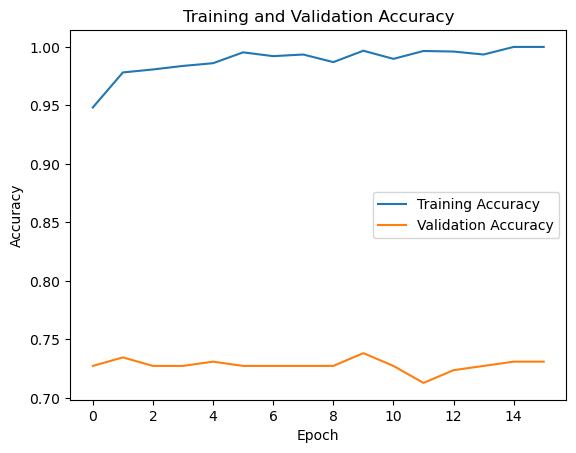

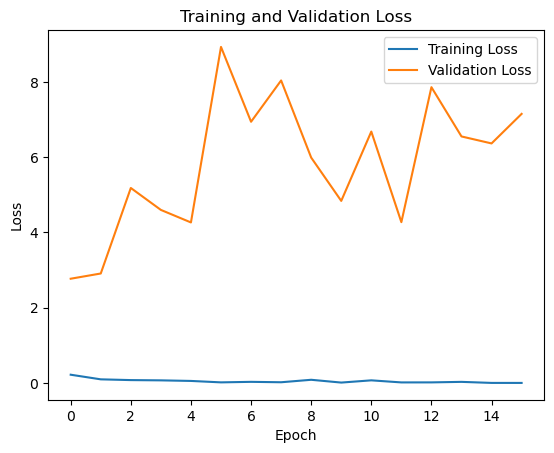

In [35]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 188s 7s/step - accuracy: 0.6850 - loss: 1.2266
Test Accuracy: 85.04%
Test Loss: 0.6077


In [37]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
#predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = (predictions > 0.5).astype(int).flatten()
predicted_labels

27/27 ━━━━━━━━━━━━━━━━━━━━ 188s 7s/step


array([0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

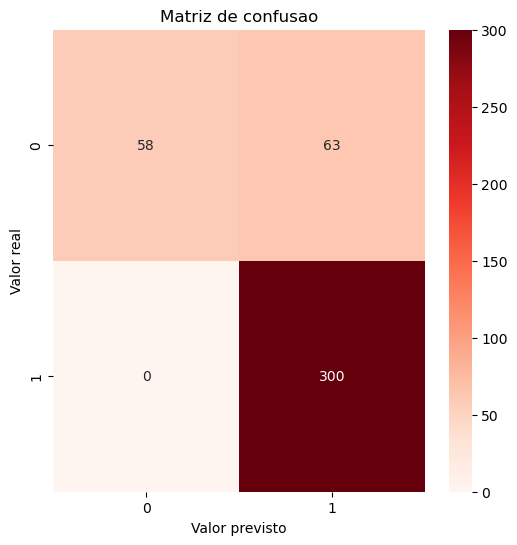

In [39]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [40]:
accuracy_from_confusion = np.trace(confusion) / np.sum(confusion)
print(f'Precisao da matriz de confusao: {accuracy_from_confusion * 100:.2f}%')

Precisao da matriz de confusao: 85.04%


In [41]:
#True negative, false positive, false negative, true positive.
TP, FN, FP, TN = confusion.ravel()

#Sensitivity a partir da definicao
sensitivity = TP / (TP + FN)
print(sensitivity)
#print(79/(79+42))

#Specifity da definicao
specificity = TN / (TN + FP)
print(specificity)
#print(296/(296+4))


0.4793388429752066
1.0
